# Speech-based Emotion Recognition for Voice Comms.
## Main Notebook

Datasets used:

*   RAVDESS, CREMA-D
*   See AugmentData.ipynb for augmentation scripts  

Models:
* Pytorch MLP
* Example sklearn RandomForest, MLP

In [1]:
import soundfile # read audio files
import numpy as np
import librosa # extract features
import glob
import os
import pickle # to save model after training
import time

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch
from torch import nn
import torch.optim as optim

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split # for splitting training and testing data
from sklearn.utils import shuffle

import seaborn as sn
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.font_manager import FontProperties
%matplotlib inline

# Data handling, feature extract

In [2]:
#device setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def extract_feature(file_name, **kwargs):
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32") # all depth 32bit float
        sample_rate = sound_file.samplerate # should always be 16kHz
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result

In [4]:
# all emotions RAVDESS
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# all emotions CREMA-D
cemotion = {
    "NEU": "neutral",
    "HAP": "happy",
    "SAD": "sad",
    "ANG": "angry",
    "FEA": "fearful",
    "DIS": "disgust",
}

tessemotion = {
    "neutral.wav": "neutral",
    "happy.wav": "happy",
    "sad.wav": "sad",
    "angry.wav": "angry",
    "fear.wav": "fearful",
    "disgust.wav": "disgust",
    "ps.wav": "surprised",
}

saveeemotion = {
    "n": "neutral",
    "h": "happy",
    "s": "sad",
    "a": "angry",
    "f": "fearful",
    "d": "disgust",
    "p": "surprised",
}

# allow only these emotions from dataset(s)
AVAILABLE_EMOTIONS = {
    "neutral",
    "calm", # only included in RAVDESS
    "happy",
    "sad",
    "angry", 
    "fearful",
    "disgust",
    "surprised" # in TESS specifies pleasant surprise
}

# allow only these emotions from dataset(s)
AVAILABLE_EMOTIONS_TEST = {
    "neutral",
    #"calm", # only included in RAVDESS
    "happy",
    "sad",
    "angry", 
    "fearful",
    "disgust",
    #"surprised" # in TESS specifies pleasant surprise
}



# map emotion to 2D space
circumplex_model = {
    "neutral":[(0.0, 0.0),"grey"],
    "calm":[(0.5, -0.7),"cyan"], # only included in RAVDESS
    "happy":[(0.8, 0.1),"purple"],
    "sad":[(-0.8, -0.3),"blue"],
    "angry":[(-0.2, 0.7),"red"],
    "fearful":[(-0.4, 0.7),"magenta"], #circumplex afraid
    "disgust":[(-0.41, 0.6),"green"], #circumplex annoyed
    "surprised":[(0.3, 0.7),"orange"], #circumplex astonished, in TESS specifies pleasant surprise
}

# map emotion to 3d space
pad_model = {
    
}

In [5]:
# load data and extract features
X, y = [], []

## RAVDESS clean
for file in glob.glob("data/RAVDESS-nosil/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = int2emotion[basename.split("-")[2]]
    # we allow only circumplex model emotions
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file, mfcc=True)
    # add to data
    X.append(features)
    y.append(circumplex_coord)

## RAVDESS augmented
# white noise
for file in glob.glob("data/augment-wn/RAVDESS/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = int2emotion[basename.split("-")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file, mfcc=True)
    # add to data
    X.append(features)
    y.append(circumplex_coord)
    
# background noise
for file in glob.glob("data/augment-bg/RAVDESS/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = int2emotion[basename.split("-")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file, mfcc=True)
    # add to data
    X.append(features)
    y.append(circumplex_coord)
    
# reverb
for file in glob.glob("data/augment-reverb/RAVDESS/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = int2emotion[basename.split("-")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file, mfcc=True)
    # add to data
    X.append(features)
    y.append(circumplex_coord)

# overdrive
for file in glob.glob("data/augment-overdrive/RAVDESS/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = int2emotion[basename.split("-")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file, mfcc=True)
    # add to data
    X.append(features)
    y.append(circumplex_coord)
    
# CREMA-D clean
for file in glob.glob("data/CREMA-D/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = cemotion[basename.split("_")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file, mfcc=True)
    # add to data
    X.append(features)
    y.append(circumplex_coord)
    
## CREMA-D augmented
# white noise
for file in glob.glob("data/augment-wn/CREMA-D/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = cemotion[basename.split("_")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file, mfcc=True)
    # add to data
    X.append(features)
    y.append(circumplex_coord)
    
# background noise
for file in glob.glob("data/augment-bg/CREMA-D/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = cemotion[basename.split("_")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file, mfcc=True)
    # add to data
    X.append(features)
    y.append(circumplex_coord)
    
# reverb
for file in glob.glob("data/augment-reverb/CREMA-D/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = cemotion[basename.split("_")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file, mfcc=True)
    # add to data
    X.append(features)
    y.append(circumplex_coord)

# overdrive
for file in glob.glob("data/augment-overdrive/CREMA-D/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = cemotion[basename.split("_")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file, mfcc=True)
    # add to data
    X.append(features)
    y.append(circumplex_coord)

# scale features
X = preprocessing.normalize(X, norm='l2', axis=1, copy=False)

# train test validation split
train_ratio = 0.7
validation_ratio = 0.25 #play with these!
test_ratio = 0.05

X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=1 - train_ratio, random_state=420, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=420, stratify=y_test)

# # label encoding for y
# label_encoder = preprocessing.LabelEncoder()
# label_encoder.fit(y)
# print("Class mapping: ")
# for i, item in enumerate(label_encoder.classes_):
#     print(item, "-->", i)

# encoded_labels = label_encoder.transform(y)
# print("Labels =", labels)
# print("Encoded labels =", list(encoded_labels))

In [30]:
# Custom test set load, overwrites
Xt, yt = [], []

# TESS
for file in glob.glob("data/TESS/*/*.wav"):
    # get the base name of the audio file\n",
    basename = os.path.basename(file)
    # get the emotion label\n",
    emotion = tessemotion[basename.split("_")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS_TEST:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract speech features
    features = extract_feature(file, mfcc=True)
    # add to data
    Xt.append(features)
    yt.append(circumplex_coord)
    
# # TESS Augmentations
# # white noise
# for file in glob.glob("data/augment-wn/TESS/*.wav"):
#     # get the base name of the audio file
#     basename = os.path.basename(file)
#     # get the emotion label
#     emotion = tessemotion[basename.split("_")[2]]
#     # we allow only AVAILABLE_EMOTIONS we set
#     if emotion not in AVAILABLE_EMOTIONS:
#         continue
#     # map coords
#     circumplex_coord = circumplex_model[emotion][0]
#     # extract features
#     features = extract_feature(file, mfcc=True)
#     # add to data
#     Xt.append(features)
#     yt.append(circumplex_coord)
    
# # background noise
# for file in glob.glob("data/augment-bg/TESS/*.wav"):
#     # get the base name of the audio file
#     basename = os.path.basename(file)
#     # get the emotion label
#     emotion = tessemotion[basename.split("_")[2]]
#     # we allow only AVAILABLE_EMOTIONS we set
#     if emotion not in AVAILABLE_EMOTIONS:
#         continue
#     # map coords
#     circumplex_coord = circumplex_model[emotion][0]
#     # extract features
#     features = extract_feature(file, mfcc=True)
#     # add to data
#     Xt.append(features)
#     yt.append(circumplex_coord)
    
# # reverb
# for file in glob.glob("data/augment-reverb/TESS/*.wav"):
#     # get the base name of the audio file
#     basename = os.path.basename(file)
#     # get the emotion label
#     emotion = tessemotion[basename.split("_")[2]]
#     # we allow only AVAILABLE_EMOTIONS we set
#     if emotion not in AVAILABLE_EMOTIONS:
#         continue
#     # map coords
#     circumplex_coord = circumplex_model[emotion][0]
#     # extract features
#     features = extract_feature(file, mfcc=True)
#     # add to data
#     Xt.append(features)
#     yt.append(circumplex_coord)

# # overdrive
# for file in glob.glob("data/augment-overdrive/TESS/*.wav"):
#     # get the base name of the audio file
#     basename = os.path.basename(file)
#     # get the emotion label
#     emotion = tessemotion[basename.split("_")[2]]
#     # we allow only AVAILABLE_EMOTIONS we set
#     if emotion not in AVAILABLE_EMOTIONS:
#         continue
#     # map coords
#     circumplex_coord = circumplex_model[emotion][0]
#     # extract features
#     features = extract_feature(file, mfcc=True)
#     # add to data
#     Xt.append(features)
#     yt.append(circumplex_coord)
    
# # SAVEE
# for file in glob.glob("data/SAVEE/*/*.wav"):
#     # get the base name of the audio file\n",
#     basename = os.path.basename(file)
#     # get the emotion label\n",
#     emotion = saveeemotion[basename[0]]
#     # we allow only AVAILABLE_EMOTIONS we set
#     if emotion not in AVAILABLE_EMOTIONS:
#         continue
#     # map coords
#     circumplex_coord = circumplex_model[emotion][0]
#     # extract speech features
#     features = extract_feature(file, mfcc=True)
#     # add to data
#     Xt.append(features)
#     yt.append(circumplex_coord)
    
Xt = preprocessing.normalize(Xt, norm='l2', axis=1, copy=False)

X_bin, X_wild, y_bin, y_wild = train_test_split(np.array(Xt), np.array(yt), test_size = 0.2, random_state = 420, stratify=yt)

In [31]:
# number of available samples
print("[+] Number of samples:", X.shape[0])
# vector of features extracted 
print("[+] Number of features:", X_train.shape[1])
# number of samples in training data
print("[+] Number of training samples:", X_train.shape[0])
# number of samples in validation data
print("[+] Number of validation samples:", X_val.shape[0])
# number of samples in test data
print("[+] Number of test samples:", X_test.shape[0])
# number of samples in wild data
print("[+] Number of wild samples:", X_wild.shape[0])

[+] Number of samples: 44410
[+] Number of features: 40
[+] Number of training samples: 31086
[+] Number of validation samples: 11103
[+] Number of test samples: 2221
[+] Number of wild samples: 480


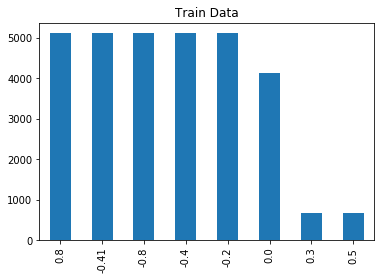

In [8]:
y_train_df = pd.DataFrame(data=y_train, columns=['X','Y',])
y_train_df['X'].value_counts().plot.bar(title='Train Data')

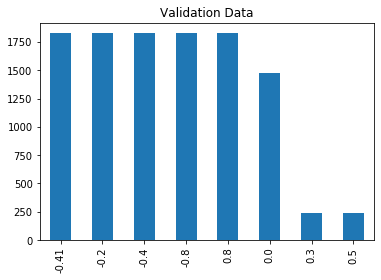

In [9]:
y_val_df = pd.DataFrame(data=y_val, columns=['X','Y',])
y_val_df['X'].value_counts().plot.bar(title='Validation Data')

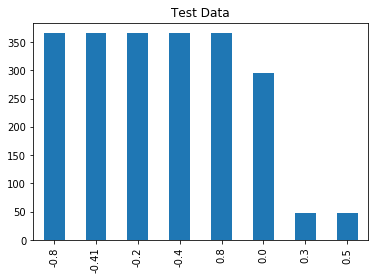

In [10]:
y_test_df = pd.DataFrame(data=y_test, columns=['X','Y',])
y_test_df['X'].value_counts().plot.bar(title='Test Data')

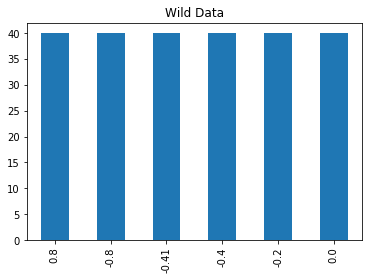

In [11]:
y_wild_df = pd.DataFrame(data=y_wild, columns=['X','Y',])
y_wild_df['X'].value_counts().plot.bar(title='Wild Data')

# MLP PyTorch

In [12]:
class DataLoader(object):
    def __init__(self, x, y, batch_size, shuffle):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.start_idx = 0
        self.data_size = x.shape[0]
        if self.shuffle:
            self.reset()
    
    def reset(self):
        self.x, self.y = shuffle(self.x, self.y)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.start_idx >= self.data_size:
            if self.shuffle:
                self.reset()
            self.start_idx = 0
            raise StopIteration
    
        batch_x = self.x[self.start_idx:self.start_idx+self.batch_size]
        batch_y = self.y[self.start_idx:self.start_idx+self.batch_size]

        batch_x = torch.tensor(batch_x, dtype=torch.float, device=device)
        batch_y = torch.tensor(batch_y, dtype=torch.float, device=device)

        self.start_idx += self.batch_size

        return (batch_x,batch_y)

In [13]:
train_loader = DataLoader(X_train, y_train,
                 batch_size=1024,
                 shuffle=True)

val_loader = DataLoader(X_val, y_val,
                 batch_size=1024,
                 shuffle=True)

print("Train Set:")
# checking the dataset
for features, labels in train_loader:  
    print('Features Dimensions:', features.shape)
    print('label dimensions:', labels.shape)
    break
    
# checking the dataset
print("Validation Set:")
for features, labels in val_loader:  
    print('Features dimensions:', features.shape)
    print('Label dimensions:', labels.shape)
    break

Train Set:
Features Dimensions: torch.Size([1024, 40])
label dimensions: torch.Size([1024, 2])
Validation Set:
Features dimensions: torch.Size([1024, 40])
Label dimensions: torch.Size([1024, 2])


In [23]:
#defining model
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim_1, hidden_dim_2, out_dim=2):
        super(MLP, self).__init__()
        
        self.in_dim = in_dim
        self.hidden_dim_1 = hidden_dim_1
        self.hidden_dim_2 = hidden_dim_2
        self.out_dim = out_dim
        
        ## 1st hidden layer
        self.linear_1 = nn.Linear(self.in_dim, self.hidden_dim_1)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        self.linear_1_bn = nn.BatchNorm1d(self.hidden_dim_1,momentum=0.6)
        
        ## 2nd hidden layer
        self.linear_2 = nn.Linear(self.hidden_dim_1, self.hidden_dim_2)
        self.linear_2.weight.detach().normal_(0.0, 0.1)
        self.linear_2.bias.detach().zero_()
        self.linear_2_bn = nn.BatchNorm1d(self.hidden_dim_2,momentum=0.6)
        
        ## Out layer
        self.linear_out = nn.Linear(self.hidden_dim_2, self.out_dim)
        self.linear_out.weight.detach().normal_(0.0, 0.1)
        self.linear_out.bias.detach().zero_()
        
    
    def forward(self, x):
        out = self.linear_1(x)
        out = self.linear_1_bn(out)
        out = F.relu(out)
        #out = F.dropout(out, p=0.15, training=self.training)
        
        out = self.linear_2(out)
        out = self.linear_2_bn(out)
        out = F.relu(out)
        out = F.dropout(out, p=0.175, training=self.training)
        
        out = self.linear_out(out)
        return out

In [15]:
#init model
mlp = MLP(40, 28, 20, 2).to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0001)

In [16]:
# training phase
epochs = 1250

# to plot loss curve after training
valid_losses = []
losses = []

for epoch in range(epochs):
    start_time = time.time()
    mlp.train()
    num_batch = train_loader.data_size // train_loader.batch_size + 1
    train_loss_epoch = 0
    
    for batch_id, (batch_x, batch_y) in enumerate(train_loader):
        
        y_pred = mlp(batch_x)

        loss = F.mse_loss(y_pred, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        elapsed_time = time.time() - start_time
        elapsed_min = int(elapsed_time / 60)
        elapsed_sec = elapsed_time - 60 * elapsed_min
        
        train_loss_epoch += loss.item()

        print('\rEpoch:{} Batch:{}/{} Loss:{:.4f} Time:{}m{:.2f}s'.format(epoch + 1, batch_id, 
                                                                          num_batch, loss.item(),
                                                                          elapsed_min, elapsed_sec), end='')
    train_loss_epoch /= num_batch
    losses.append(train_loss_epoch)
    
    print()
    mlp.eval()
    valid_loss = 0
    best_loss = np.inf
    num_batch = val_loader.data_size // val_loader.batch_size + 1
    
    for batch_id, (batch_x, batch_y) in enumerate(val_loader):
    
        y_pred = mlp(batch_x)
        loss = F.mse_loss(y_pred, batch_y)
        valid_loss += loss.item()
    
    valid_loss /= num_batch
    valid_losses.append(valid_loss)
    
    #save model when validation loss is minimum
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(mlp.state_dict(), 'mlp.bestmodel') 
    
    print('Valid Loss:{:.4f}'.format(valid_loss))

Epoch:1 Batch:29/31 Loss:0.3130 Time:0m0.27s
Valid Loss:0.2761
Epoch:2 Batch:30/31 Loss:0.2879 Time:0m0.16s
Valid Loss:0.2716
Epoch:3 Batch:30/31 Loss:0.2793 Time:0m0.17s
Valid Loss:0.2531
Epoch:4 Batch:30/31 Loss:0.2558 Time:0m0.18s
Valid Loss:0.2403
Epoch:5 Batch:30/31 Loss:0.2455 Time:0m0.17s
Valid Loss:0.2321
Epoch:6 Batch:30/31 Loss:0.2458 Time:0m0.17s
Valid Loss:0.2247
Epoch:7 Batch:30/31 Loss:0.2389 Time:0m0.16s
Valid Loss:0.2189
Epoch:8 Batch:30/31 Loss:0.2233 Time:0m0.16s
Valid Loss:0.2133
Epoch:9 Batch:30/31 Loss:0.2251 Time:0m0.24s
Valid Loss:0.2101
Epoch:10 Batch:30/31 Loss:0.2297 Time:0m0.16s
Valid Loss:0.2074
Epoch:11 Batch:30/31 Loss:0.2330 Time:0m0.16s
Valid Loss:0.2049
Epoch:12 Batch:30/31 Loss:0.1994 Time:0m0.17s
Valid Loss:0.2034
Epoch:13 Batch:30/31 Loss:0.2013 Time:0m0.18s
Valid Loss:0.2010
Epoch:14 Batch:30/31 Loss:0.2187 Time:0m0.20s
Valid Loss:0.2006
Epoch:15 Batch:30/31 Loss:0.2122 Time:0m0.18s
Valid Loss:0.1996
Epoch:16 Batch:30/31 Loss:0.2132 Time:0m0.16s
Val

Epoch:128 Batch:30/31 Loss:0.1785 Time:0m0.17s
Valid Loss:0.1818
Epoch:129 Batch:30/31 Loss:0.1875 Time:0m0.15s
Valid Loss:0.1815
Epoch:130 Batch:30/31 Loss:0.1899 Time:0m0.15s
Valid Loss:0.1817
Epoch:131 Batch:30/31 Loss:0.1796 Time:0m0.18s
Valid Loss:0.1817
Epoch:132 Batch:30/31 Loss:0.1700 Time:0m0.18s
Valid Loss:0.1816
Epoch:133 Batch:30/31 Loss:0.1895 Time:0m0.15s
Valid Loss:0.1814
Epoch:134 Batch:30/31 Loss:0.1745 Time:0m0.15s
Valid Loss:0.1820
Epoch:135 Batch:30/31 Loss:0.1733 Time:0m0.18s
Valid Loss:0.1813
Epoch:136 Batch:30/31 Loss:0.1898 Time:0m0.15s
Valid Loss:0.1815
Epoch:137 Batch:30/31 Loss:0.1830 Time:0m0.17s
Valid Loss:0.1809
Epoch:138 Batch:30/31 Loss:0.1728 Time:0m0.16s
Valid Loss:0.1811
Epoch:139 Batch:30/31 Loss:0.1749 Time:0m0.16s
Valid Loss:0.1818
Epoch:140 Batch:30/31 Loss:0.1798 Time:0m0.16s
Valid Loss:0.1808
Epoch:141 Batch:30/31 Loss:0.1831 Time:0m0.15s
Valid Loss:0.1813
Epoch:142 Batch:30/31 Loss:0.1965 Time:0m0.16s
Valid Loss:0.1813
Epoch:143 Batch:30/31 Los

Epoch:254 Batch:30/31 Loss:0.1882 Time:0m0.15s
Valid Loss:0.1772
Epoch:255 Batch:30/31 Loss:0.1755 Time:0m0.15s
Valid Loss:0.1775
Epoch:256 Batch:30/31 Loss:0.1742 Time:0m0.16s
Valid Loss:0.1781
Epoch:257 Batch:30/31 Loss:0.1729 Time:0m0.18s
Valid Loss:0.1773
Epoch:258 Batch:30/31 Loss:0.1794 Time:0m0.18s
Valid Loss:0.1776
Epoch:259 Batch:30/31 Loss:0.1814 Time:0m0.15s
Valid Loss:0.1774
Epoch:260 Batch:30/31 Loss:0.1794 Time:0m0.18s
Valid Loss:0.1775
Epoch:261 Batch:30/31 Loss:0.1731 Time:0m0.15s
Valid Loss:0.1780
Epoch:262 Batch:30/31 Loss:0.1758 Time:0m0.15s
Valid Loss:0.1772
Epoch:263 Batch:30/31 Loss:0.1857 Time:0m0.23s
Valid Loss:0.1771
Epoch:264 Batch:30/31 Loss:0.1594 Time:0m0.14s
Valid Loss:0.1774
Epoch:265 Batch:30/31 Loss:0.1785 Time:0m0.15s
Valid Loss:0.1770
Epoch:266 Batch:30/31 Loss:0.1634 Time:0m0.15s
Valid Loss:0.1769
Epoch:267 Batch:30/31 Loss:0.1776 Time:0m0.18s
Valid Loss:0.1768
Epoch:268 Batch:30/31 Loss:0.1762 Time:0m0.17s
Valid Loss:0.1771
Epoch:269 Batch:30/31 Los

Epoch:380 Batch:30/31 Loss:0.1617 Time:0m0.15s
Valid Loss:0.1750
Epoch:381 Batch:30/31 Loss:0.1763 Time:0m0.17s
Valid Loss:0.1752
Epoch:382 Batch:30/31 Loss:0.1914 Time:0m0.18s
Valid Loss:0.1747
Epoch:383 Batch:30/31 Loss:0.1749 Time:0m0.15s
Valid Loss:0.1748
Epoch:384 Batch:30/31 Loss:0.1811 Time:0m0.15s
Valid Loss:0.1748
Epoch:385 Batch:30/31 Loss:0.1656 Time:0m0.16s
Valid Loss:0.1753
Epoch:386 Batch:30/31 Loss:0.1779 Time:0m0.19s
Valid Loss:0.1759
Epoch:387 Batch:30/31 Loss:0.1821 Time:0m0.15s
Valid Loss:0.1747
Epoch:388 Batch:30/31 Loss:0.1716 Time:0m0.15s
Valid Loss:0.1748
Epoch:389 Batch:30/31 Loss:0.1747 Time:0m0.16s
Valid Loss:0.1746
Epoch:390 Batch:30/31 Loss:0.1838 Time:0m0.16s
Valid Loss:0.1747
Epoch:391 Batch:30/31 Loss:0.1867 Time:0m0.17s
Valid Loss:0.1748
Epoch:392 Batch:30/31 Loss:0.1675 Time:0m0.16s
Valid Loss:0.1747
Epoch:393 Batch:30/31 Loss:0.1815 Time:0m0.18s
Valid Loss:0.1743
Epoch:394 Batch:30/31 Loss:0.1866 Time:0m0.15s
Valid Loss:0.1747
Epoch:395 Batch:30/31 Los

Epoch:506 Batch:30/31 Loss:0.1737 Time:0m0.17s
Valid Loss:0.1726
Epoch:507 Batch:30/31 Loss:0.1816 Time:0m0.15s
Valid Loss:0.1727
Epoch:508 Batch:30/31 Loss:0.1669 Time:0m0.15s
Valid Loss:0.1738
Epoch:509 Batch:30/31 Loss:0.1808 Time:0m0.18s
Valid Loss:0.1733
Epoch:510 Batch:30/31 Loss:0.1713 Time:0m0.19s
Valid Loss:0.1737
Epoch:511 Batch:30/31 Loss:0.1841 Time:0m0.15s
Valid Loss:0.1733
Epoch:512 Batch:30/31 Loss:0.1762 Time:0m0.18s
Valid Loss:0.1739
Epoch:513 Batch:30/31 Loss:0.1741 Time:0m0.15s
Valid Loss:0.1727
Epoch:514 Batch:30/31 Loss:0.1802 Time:0m0.15s
Valid Loss:0.1731
Epoch:515 Batch:30/31 Loss:0.1754 Time:0m0.18s
Valid Loss:0.1725
Epoch:516 Batch:30/31 Loss:0.1669 Time:0m0.18s
Valid Loss:0.1731
Epoch:517 Batch:30/31 Loss:0.1782 Time:0m0.15s
Valid Loss:0.1727
Epoch:518 Batch:30/31 Loss:0.1857 Time:0m0.15s
Valid Loss:0.1733
Epoch:519 Batch:30/31 Loss:0.1708 Time:0m0.18s
Valid Loss:0.1729
Epoch:520 Batch:30/31 Loss:0.1710 Time:0m0.15s
Valid Loss:0.1729
Epoch:521 Batch:30/31 Los

Epoch:632 Batch:30/31 Loss:0.1683 Time:0m0.18s
Valid Loss:0.1719
Epoch:633 Batch:30/31 Loss:0.1663 Time:0m0.18s
Valid Loss:0.1725
Epoch:634 Batch:30/31 Loss:0.1517 Time:0m0.15s
Valid Loss:0.1727
Epoch:635 Batch:30/31 Loss:0.1639 Time:0m0.15s
Valid Loss:0.1719
Epoch:636 Batch:30/31 Loss:0.1642 Time:0m0.18s
Valid Loss:0.1719
Epoch:637 Batch:30/31 Loss:0.1602 Time:0m0.18s
Valid Loss:0.1719
Epoch:638 Batch:30/31 Loss:0.1634 Time:0m0.15s
Valid Loss:0.1716
Epoch:639 Batch:30/31 Loss:0.1722 Time:0m0.18s
Valid Loss:0.1718
Epoch:640 Batch:30/31 Loss:0.1701 Time:0m0.15s
Valid Loss:0.1716
Epoch:641 Batch:30/31 Loss:0.1673 Time:0m0.15s
Valid Loss:0.1729
Epoch:642 Batch:30/31 Loss:0.1737 Time:0m0.19s
Valid Loss:0.1717
Epoch:643 Batch:30/31 Loss:0.1780 Time:0m0.18s
Valid Loss:0.1716
Epoch:644 Batch:30/31 Loss:0.1651 Time:0m0.16s
Valid Loss:0.1728
Epoch:645 Batch:30/31 Loss:0.1632 Time:0m0.15s
Valid Loss:0.1716
Epoch:646 Batch:30/31 Loss:0.1725 Time:0m0.16s
Valid Loss:0.1720
Epoch:647 Batch:30/31 Los

Epoch:758 Batch:30/31 Loss:0.1707 Time:0m0.15s
Valid Loss:0.1714
Epoch:759 Batch:30/31 Loss:0.1610 Time:0m0.15s
Valid Loss:0.1710
Epoch:760 Batch:30/31 Loss:0.1730 Time:0m0.24s
Valid Loss:0.1711
Epoch:761 Batch:30/31 Loss:0.1725 Time:0m0.17s
Valid Loss:0.1711
Epoch:762 Batch:30/31 Loss:0.1801 Time:0m0.15s
Valid Loss:0.1714
Epoch:763 Batch:30/31 Loss:0.1766 Time:0m0.17s
Valid Loss:0.1711
Epoch:764 Batch:30/31 Loss:0.1726 Time:0m0.16s
Valid Loss:0.1718
Epoch:765 Batch:30/31 Loss:0.1740 Time:0m0.16s
Valid Loss:0.1709
Epoch:766 Batch:30/31 Loss:0.1713 Time:0m0.15s
Valid Loss:0.1705
Epoch:767 Batch:30/31 Loss:0.1659 Time:0m0.17s
Valid Loss:0.1703
Epoch:768 Batch:30/31 Loss:0.1679 Time:0m0.16s
Valid Loss:0.1712
Epoch:769 Batch:30/31 Loss:0.1754 Time:0m0.15s
Valid Loss:0.1713
Epoch:770 Batch:30/31 Loss:0.1755 Time:0m0.19s
Valid Loss:0.1707
Epoch:771 Batch:30/31 Loss:0.1783 Time:0m0.21s
Valid Loss:0.1703
Epoch:772 Batch:30/31 Loss:0.1634 Time:0m0.15s
Valid Loss:0.1708
Epoch:773 Batch:30/31 Los

Epoch:885 Batch:30/31 Loss:0.1726 Time:0m0.18s
Valid Loss:0.1699
Epoch:886 Batch:30/31 Loss:0.1550 Time:0m0.18s
Valid Loss:0.1698
Epoch:887 Batch:30/31 Loss:0.1630 Time:0m0.16s
Valid Loss:0.1700
Epoch:888 Batch:30/31 Loss:0.1697 Time:0m0.15s
Valid Loss:0.1708
Epoch:889 Batch:30/31 Loss:0.1618 Time:0m0.17s
Valid Loss:0.1696
Epoch:890 Batch:30/31 Loss:0.1601 Time:0m0.19s
Valid Loss:0.1698
Epoch:891 Batch:30/31 Loss:0.1609 Time:0m0.15s
Valid Loss:0.1701
Epoch:892 Batch:30/31 Loss:0.1734 Time:0m0.16s
Valid Loss:0.1710
Epoch:893 Batch:30/31 Loss:0.1557 Time:0m0.17s
Valid Loss:0.1700
Epoch:894 Batch:30/31 Loss:0.1666 Time:0m0.15s
Valid Loss:0.1714
Epoch:895 Batch:30/31 Loss:0.1799 Time:0m0.18s
Valid Loss:0.1703
Epoch:896 Batch:30/31 Loss:0.1636 Time:0m0.16s
Valid Loss:0.1702
Epoch:897 Batch:30/31 Loss:0.1641 Time:0m0.15s
Valid Loss:0.1703
Epoch:898 Batch:30/31 Loss:0.1768 Time:0m0.14s
Valid Loss:0.1710
Epoch:899 Batch:30/31 Loss:0.1652 Time:0m0.15s
Valid Loss:0.1708
Epoch:900 Batch:30/31 Los

Epoch:1011 Batch:30/31 Loss:0.1694 Time:0m0.17s
Valid Loss:0.1697
Epoch:1012 Batch:30/31 Loss:0.1656 Time:0m0.19s
Valid Loss:0.1698
Epoch:1013 Batch:30/31 Loss:0.1731 Time:0m0.16s
Valid Loss:0.1695
Epoch:1014 Batch:30/31 Loss:0.1663 Time:0m0.21s
Valid Loss:0.1701
Epoch:1015 Batch:30/31 Loss:0.1579 Time:0m0.17s
Valid Loss:0.1686
Epoch:1016 Batch:30/31 Loss:0.1687 Time:0m0.16s
Valid Loss:0.1697
Epoch:1017 Batch:30/31 Loss:0.1653 Time:0m0.15s
Valid Loss:0.1703
Epoch:1018 Batch:30/31 Loss:0.1662 Time:0m0.15s
Valid Loss:0.1704
Epoch:1019 Batch:30/31 Loss:0.1553 Time:0m0.19s
Valid Loss:0.1694
Epoch:1020 Batch:30/31 Loss:0.1656 Time:0m0.15s
Valid Loss:0.1703
Epoch:1021 Batch:30/31 Loss:0.1634 Time:0m0.15s
Valid Loss:0.1696
Epoch:1022 Batch:30/31 Loss:0.1609 Time:0m0.16s
Valid Loss:0.1695
Epoch:1023 Batch:30/31 Loss:0.1845 Time:0m0.16s
Valid Loss:0.1693
Epoch:1024 Batch:30/31 Loss:0.1657 Time:0m0.19s
Valid Loss:0.1693
Epoch:1025 Batch:30/31 Loss:0.1499 Time:0m0.18s
Valid Loss:0.1690
Epoch:1026

Epoch:1135 Batch:30/31 Loss:0.1779 Time:0m0.23s
Valid Loss:0.1697
Epoch:1136 Batch:30/31 Loss:0.1730 Time:0m0.15s
Valid Loss:0.1688
Epoch:1137 Batch:30/31 Loss:0.1627 Time:0m0.18s
Valid Loss:0.1696
Epoch:1138 Batch:30/31 Loss:0.1525 Time:0m0.16s
Valid Loss:0.1690
Epoch:1139 Batch:30/31 Loss:0.1626 Time:0m0.16s
Valid Loss:0.1687
Epoch:1140 Batch:30/31 Loss:0.1582 Time:0m0.19s
Valid Loss:0.1689
Epoch:1141 Batch:30/31 Loss:0.1700 Time:0m0.15s
Valid Loss:0.1690
Epoch:1142 Batch:30/31 Loss:0.1722 Time:0m0.16s
Valid Loss:0.1691
Epoch:1143 Batch:30/31 Loss:0.1787 Time:0m0.15s
Valid Loss:0.1687
Epoch:1144 Batch:30/31 Loss:0.1607 Time:0m0.18s
Valid Loss:0.1688
Epoch:1145 Batch:30/31 Loss:0.1697 Time:0m0.17s
Valid Loss:0.1686
Epoch:1146 Batch:30/31 Loss:0.1731 Time:0m0.14s
Valid Loss:0.1691
Epoch:1147 Batch:30/31 Loss:0.1602 Time:0m0.17s
Valid Loss:0.1707
Epoch:1148 Batch:30/31 Loss:0.1634 Time:0m0.15s
Valid Loss:0.1695
Epoch:1149 Batch:30/31 Loss:0.1579 Time:0m0.18s
Valid Loss:0.1688
Epoch:1150

minimum validation loss is 0.1684


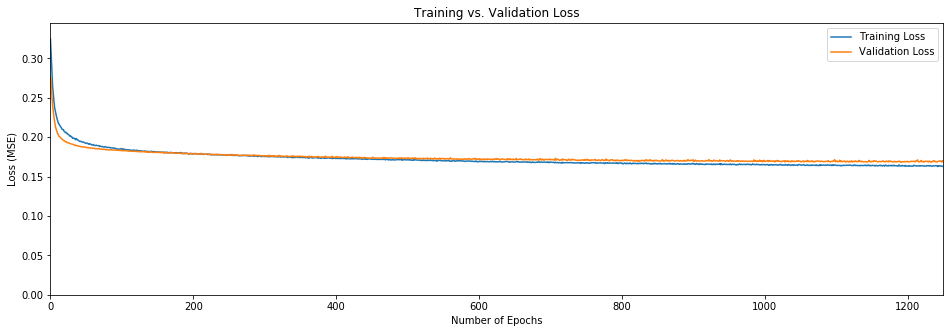

In [24]:
# plot validation loss curve
plt.figure(figsize=(16,5))
plt.title("Training vs. Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss (MSE)")
plt.ylim(0,max(losses)+0.02)
plt.xlim(0,epochs)
plt.plot(losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
print('minimum validation loss is {:.4f}'.format(min(valid_losses)))

## Testing

In [25]:
#load the best model
mlp.load_state_dict(torch.load('mlp.bestmodel'))

<All keys matched successfully>

In [26]:
# test data from initial split 
x_test = torch.tensor(X_test, dtype=torch.float, device=device)

#predict
y_pred = mlp(x_test)
y_pred = y_pred.data.cpu().numpy()

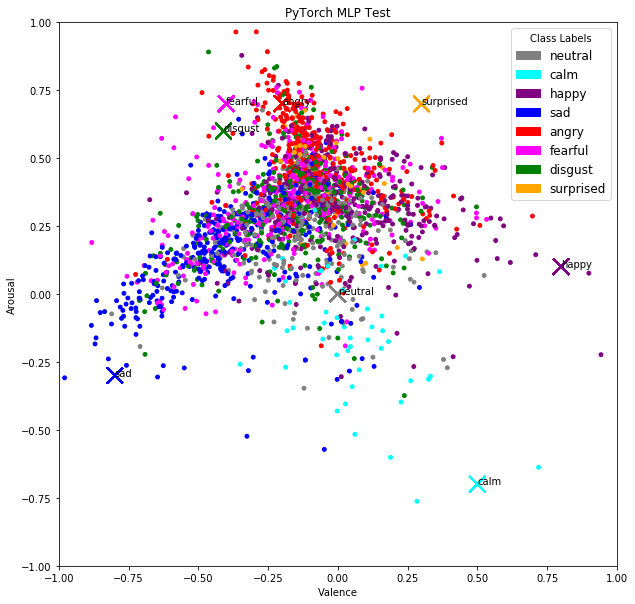

      True x  True y    Pred x    Pred y
0       0.50    -0.7  0.022767 -0.121291
1      -0.40     0.7 -0.439679  0.208335
2       0.30     0.7 -0.143260  0.568539
3      -0.80    -0.3 -0.297293  0.214306
4       0.50    -0.7 -0.193904  0.237939
...      ...     ...       ...       ...
2216   -0.80    -0.3 -0.023183 -0.110566
2217   -0.41     0.6 -0.226928  0.831420
2218   -0.41     0.6 -0.572206  0.038267
2219   -0.20     0.7  0.236909  0.349126
2220    0.00     0.0 -0.133540  0.251164

[2221 rows x 4 columns]

Mean Absolute Error: 0.33613055607522646
Mean Squared Error: 0.16748777564165918
Root Mean Squared Error: 0.40925270389046814


In [27]:
# plotting test
fontP = FontProperties()
fontP.set_size('large')

plt.figure(figsize=(10,10))
plt.title('PyTorch MLP Test')
# im = plt.imread("imshow/circumplex-model.png",0)
# implot = plt.imshow(im,extent=[y_train[:,0].min(),y_train[:,0].max(),y_train[:,1].min(),y_train[:,1].max()])

colors = []

for i in range(len(y_test)):
    for key, value in circumplex_model.items():
        if tuple(y_test[i]) == value[0]:
            colors.append(value[1])

plt.scatter(y_test[:,0], y_test[:,1], color=colors, s=250, marker='x')
plt.scatter(y_pred[:,0], y_pred[:,1], c=colors, s=15, marker='o')

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.xlabel("Valence")
plt.ylabel("Arousal")

plt.xticks()
plt.yticks()

for key, value in circumplex_model.items():
    plt.annotate(key, value[0])

# legend
grey_patch = mpatches.Patch(color='grey', label='neutral')
cyan_patch = mpatches.Patch(color='cyan', label='calm')
purple_patch = mpatches.Patch(color='purple', label='happy')
blue_patch = mpatches.Patch(color='blue', label='sad')
red_patch = mpatches.Patch(color='red', label='angry')
magenta_patch = mpatches.Patch(color='magenta', label='fearful')
green_patch = mpatches.Patch(color='green', label='disgust')
orange_patch = mpatches.Patch(color='orange', label='surprised')

plt.legend(title="Class Labels",handles=[
                    grey_patch,
                    cyan_patch,
                    purple_patch,
                    blue_patch,
                    red_patch,
                    magenta_patch,
                    green_patch,
                    orange_patch],
#                     bbox_to_anchor=(1, 1),
                    prop=fontP)

plt.show()

df_mlp_test = pd.DataFrame({'True x':y_test[:,0], 
                       'True y':y_test[:,1],
                       'Pred x':y_pred[:,0], 
                       'Pred y':y_pred[:,1]})

print(df_mlp_test)
print()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [32]:
# wild test data
x_wild = torch.tensor(X_wild, dtype=torch.float, device=device)

#predict
y_pred = mlp(x_wild)
y_pred = y_pred.data.cpu().numpy()

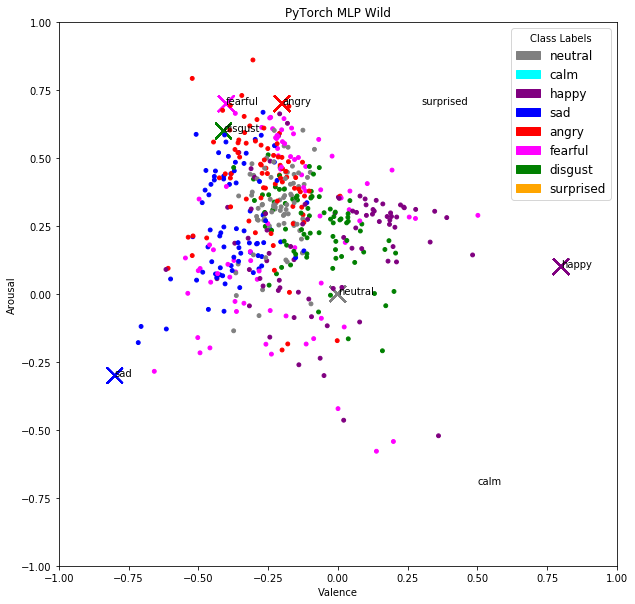

     True x  True y    Pred x    Pred y
0      -0.2     0.7 -0.295591  0.225377
1       0.0     0.0 -0.156721  0.440119
2      -0.4     0.7 -0.115100  0.469139
3      -0.8    -0.3 -0.400978  0.559276
4      -0.4     0.7 -0.198409  0.560460
..      ...     ...       ...       ...
475    -0.8    -0.3 -0.336029  0.232288
476    -0.2     0.7 -0.519025  0.213711
477     0.8     0.1  0.067078  0.300272
478     0.8     0.1  0.360803 -0.521604
479     0.8     0.1  0.130494  0.304902

[480 rows x 4 columns]

Mean Absolute Error: 0.3608692289811247
Mean Squared Error: 0.19289338237882442
Root Mean Squared Error: 0.4391962913992153


In [33]:
# plotting wild
fontP = FontProperties()
fontP.set_size('large')

plt.figure(figsize=(10,10))
plt.title('PyTorch MLP Wild')
# im = plt.imread("imshow/circumplex-model.png",0)
# implot = plt.imshow(im,extent=[y_train[:,0].min(),y_train[:,0].max(),y_train[:,1].min(),y_train[:,1].max()])

colors = []

for i in range(len(y_wild)):
    for key, value in circumplex_model.items():
        if tuple(y_wild[i]) == value[0]:
            colors.append(value[1])

plt.scatter(y_wild[:,0], y_wild[:,1], color=colors, s=250, marker='x')
plt.scatter(y_pred[:,0], y_pred[:,1], c=colors, s=15, marker='o')

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.xlabel("Valence")
plt.ylabel("Arousal")

plt.xticks()
plt.yticks()

for key, value in circumplex_model.items():
    plt.annotate(key, value[0])

# legend
grey_patch = mpatches.Patch(color='grey', label='neutral')
cyan_patch = mpatches.Patch(color='cyan', label='calm')
purple_patch = mpatches.Patch(color='purple', label='happy')
blue_patch = mpatches.Patch(color='blue', label='sad')
red_patch = mpatches.Patch(color='red', label='angry')
magenta_patch = mpatches.Patch(color='magenta', label='fearful')
green_patch = mpatches.Patch(color='green', label='disgust')
orange_patch = mpatches.Patch(color='orange', label='surprised')

plt.legend(title="Class Labels",handles=[
                    grey_patch,
                    cyan_patch,
                    purple_patch,
                    blue_patch,
                    red_patch,
                    magenta_patch,
                    green_patch,
                    orange_patch],
#                     bbox_to_anchor=(1, 1),
                    prop=fontP)

plt.show()

df_mlp_wild = pd.DataFrame({'True x':y_wild[:,0], 
                       'True y':y_wild[:,1],
                       'Pred x':y_pred[:,0], 
                       'Pred y':y_pred[:,1]})

print(df_mlp_wild)
print()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_wild, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_wild, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_wild, y_pred)))

# Sklearn MLPRegressor and RandomForestRegressor

In [ ]:
mlp_params = {
    'batch_size': 'auto',
    'epsilon': 1e-08, 
    'hidden_layer_sizes': (300,), 
    'learning_rate': 'adaptive', 
    'max_iter': 100, 
    'verbose':1,
    'n_iter_no_change':10,
    'early_stopping':True,
    'random_state':420,
}

In [ ]:
mlp = MLPRegressor(**mlp_params)
mlp.out_activation_ = 'logistic'
mlp.fit(X_train, y_train)

In [ ]:
y_predict_mlp = mlp.predict(X_test)

In [ ]:
rfr_params = {
    'verbose': 10,
    'n_estimators': 100,
    'max_depth': None,
    'random_state': 420,
    'min_samples_split': 4,
    'min_samples_leaf': 3,
}

In [ ]:
# init regr
rfr = RandomForestRegressor(**rfr_params)

In [ ]:
# train the model
print("[*] Training the model...")
rfr.fit(X_train, y_train)

In [ ]:
y_predict_rfr = rfr.predict(X_test)

In [ ]:
# plotting
plt.figure(figsize=(10,10))
plt.title('RandomForestRegressor')
# im = plt.imread("imshow/circumplex-model.png",0)
# implot = plt.imshow(im,extent=[y_train[:,0].min(),y_train[:,0].max(),y_train[:,1].min(),y_train[:,1].max()])

colors = []

for i in range(len(y_test)):
    for key, value in circumplex_model.items():
        if tuple(y_test[i]) == value[0]:
            colors.append(value[1])

plt.scatter(y_test[:,0], y_test[:,1], color='black', s=15, marker='x')
plt.scatter(y_predict_rfr[:,0],y_predict_rfr[:,1], c=colors, s=15, marker='o')

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.xticks([])
plt.yticks([])

for key, value in circumplex_model.items():
    plt.annotate(key, value[0])

# legend
black_patch = mpatches.Patch(color='black', label='ground truth')
grey_patch = mpatches.Patch(color='grey', label='neutral')
cyan_patch = mpatches.Patch(color='cyan', label='calm')
purple_patch = mpatches.Patch(color='purple', label='happy')
blue_patch = mpatches.Patch(color='blue', label='sad')
red_patch = mpatches.Patch(color='red', label='angry')
magenta_patch = mpatches.Patch(color='magenta', label='fearful')
green_patch = mpatches.Patch(color='green', label='disgust')
orange_patch = mpatches.Patch(color='orange', label='surprised')

plt.legend(handles=[black_patch,
                    grey_patch,
                    cyan_patch,
                    purple_patch,
                    blue_patch,
                    red_patch,
                    magenta_patch,
                    green_patch,
                    orange_patch])

plt.show()

df_rfr = pd.DataFrame({'True x':y_test[:,0], 
                        'True y':y_test[:,1],
                        'Pred x':y_predict_rfr[:,0], 
                        'Pred y':y_predict_rfr[:,1]})
print(df_rfr)
print()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict_rfr))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict_rfr))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict_rfr)))

In [ ]:
# plotting
plt.figure(figsize=(10,10))
plt.title('MLPRegressor')
# im = plt.imread("imshow/circumplex-model.png",0)
# implot = plt.imshow(im,extent=[y_train[:,0].min(),y_train[:,0].max(),y_train[:,1].min(),y_train[:,1].max()])

colors = []

for i in range(len(y_test)):
    for key, value in circumplex_model.items():
        if tuple(y_test[i]) == value[0]:
            colors.append(value[1])

plt.scatter(y_test[:,0], y_test[:,1], color='black', s=15, marker='x')
plt.scatter(y_predict_mlp[:,0],y_predict_mlp[:,1], c=colors, s=15, marker='o')

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.xticks([])
plt.yticks([])

for key, value in circumplex_model.items():
    plt.annotate(key, value[0])

# legend
black_patch = mpatches.Patch(color='black', label='ground truth')
grey_patch = mpatches.Patch(color='grey', label='neutral')
cyan_patch = mpatches.Patch(color='cyan', label='calm')
purple_patch = mpatches.Patch(color='purple', label='happy')
blue_patch = mpatches.Patch(color='blue', label='sad')
red_patch = mpatches.Patch(color='red', label='angry')
magenta_patch = mpatches.Patch(color='magenta', label='fearful')
green_patch = mpatches.Patch(color='green', label='disgust')
orange_patch = mpatches.Patch(color='orange', label='surprised')

plt.legend(handles=[black_patch,
                    grey_patch,
                    cyan_patch,
                    purple_patch,
                    blue_patch,
                    red_patch,
                    magenta_patch,
                    green_patch,
                    orange_patch])

plt.show()

df_rfr = pd.DataFrame({'True x':y_test[:,0], 
                        'True y':y_test[:,1],
                        'Pred x':y_predict_mlp[:,0], 
                        'Pred y':y_predict_mlp[:,1]})
print(df_rfr)
print()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict_mlp))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict_mlp))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict_mlp)))

In [ ]:
# save the model
# make result directory if doesn't exist yet
if not os.path.isdir("result"):
    os.mkdir("result")

pickle.dump(rfr, open("result/rfr.model", "wb"))